<b>ФИО:</b> <i>Cенчило П. В.</i>;
<br><b>ДЗ №:</b> `2` = <b>Блок</b> № `3`;
<br><b>Дата:</b> `2023-10-23`.

**Тема:**
"Домашнее задание — мультиклассовая классификация по вопросам о языках программирования на Stack Overflow"

# Классификация текстов
# Домашнее задание — мультиклассовая классификация по вопросам о языках программирования на Stack Overflow

В новой задаче используется датасет с несколькими тысячами вопросов по четырём языкам программирования со Stack Overflow. Он извлечён из датасета [BigQuery](https://console.cloud.google.com/marketplace/details/stack-exchange/stack-overflow) с более чем 17 миллионами вопросов.

Все упоминания целевых языков программирования в данных заменены на *blank*.

Необходимо внести в учебный блокнот по классификации данных с IMDB следующие изменения:

- Скачать новый подготовленный набор данных (датасет): [Stack Overflow dataset](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) (адрес: https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz).

Структура файлов  в архиве с данными:

```
train/
...python/
......0.txt
......1.txt
...javascript/
......0.txt
......1.txt
...csharp/
......0.txt
......1.txt
...java/
......0.txt
......1.txt
```

Изменить части кода, отвечающие новой задаче классификации, которая теперь мультиклассовая:

- Заменить размерность последнего полносвязного слоя для нового количества предсказываемых классов.

- Использовать функцию потерь, подходящую для целочисленных меток классов: `tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)`. Метрика должна иметь значение `metrics=['accuracy']` (`tf.metrics.BinaryAccuracy` только для бинарной классификации.

- При построении графиков скорректируйте метрики на те, которые реально используются вами в решении.


# Для основы возьмите бинарный случай классификации, который был разобран на уроке.

In [1]:
#

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from keras import layers
from keras import losses

In [2]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset = tf.keras.utils.get_file(
    "stack_overflow_16k", url, untar=True, cache_dir=".", cache_subdir=".dataset"
)

dataset_dir = os.path.dirname(dataset)

In [3]:
os.listdir(dataset_dir)

['README.md', 'stack_overflow_16k.tar.gz', 'test', 'train']

In [4]:
train_dir = os.path.join(dataset_dir, "train")
os.listdir(train_dir)

['csharp', 'java', 'javascript', 'python']

In [5]:
sample_file = os.path.join(train_dir, "python/0.txt")
with open(sample_file) as f:
    print(f.read())

"is it legal to define two methods with the same name but different returning types? i've written a piece of code to determine a typical palindrome string. i did this by the definition of a reverse() method returning a string. i also eager to have the same method, but in the void form, because of some future needs..as i add the latter to the code, the valid output will become invalid..so, the question is that is it legal to define two methods with the same name but different returning types?.if not, please let me know how to write this code with the void-type method...class detector(object):.    def __init__(self,string):.        self.string = string..    forbidden = (' ','!','?','.','-','_','&amp;','%',""#"","","")..    def eliminator(self):.        for item in self.forbidden:.            if item in self.string:.                self.string = self.string.replace(item,"""")..    def reverse(self):.        return self.string[::-1]            ..    #def reverse(self):.    #    self.string

In [6]:
batch_size = 32
seed = 42

raw_train_ds: tf.data.Dataset = tf.keras.utils.text_dataset_from_directory(
    ".dataset/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=seed,
)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [7]:
for text_batch, label_batch in raw_train_ds.take(1).as_numpy_iterator():
    for i in range(3):
        print("Body:", text_batch[i])
        print("Label:", label_batch[i])
        print()

Body: b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default construc

In [8]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])
print("Label 2 corresponds to", raw_train_ds.class_names[2])
print("Label 3 corresponds to", raw_train_ds.class_names[3])

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


In [9]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    ".dataset/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=seed,
)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [10]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    ".dataset/test", batch_size=batch_size
)

Found 8000 files belonging to 4 classes.


In [2]:
#

In [11]:
def custom_standardization(input_data):
    return tf.strings.regex_replace(
        tf.strings.lower(input_data), "[%s]" % re.escape(
            string.punctuation), ""
    )

In [12]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

In [13]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [14]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [15]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_post, first_label = text_batch[0], label_batch[0]
print("Post", first_post)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized post", vectorize_text(first_post, first_label))

Post tf.Tensor(b'"set blank to quit on exception? i\'m using blank 3..i\'ve been looking around for an answer to this, but i haven\'t found it yet. basically, i\'m running several blank scripts into a game engine, and each script has its own entry point...i\'d rather not add try: except blocks through all of my code, so i was wondering if it\'s at all possible to tell blank to quit (or perhaps assign a custom function to that ""callback"") on finding its first error, regardless of where or what it found? ..currently, the game engine will continue after finding and hitting an error, making it more difficult than necessary to diagnose issues since running into one error may make a subsequent script not work (as it relies on variables that the error-ing script set, for example). any ideas? ..i know that i could redirect the console to a file to allow for easier scrolling, but just capturing the first error and stopping the game prematurely would be really useful...okay, a couple of extra 

In [16]:
print("1287 ---> ", vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ", vectorize_layer.get_vocabulary()[313])
print("Vocabulary size: {}".format(len(vectorize_layer.get_vocabulary())))

1287 --->  scissors
 313 --->  source
Vocabulary size: 10000


In [17]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [3]:
#

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [28]:
embedding_dim = 50

In [29]:
model = tf.keras.Sequential(
    [
        layers.Embedding(max_features + 1, embedding_dim),
        layers.Dropout(0.2),
        layers.GlobalAveragePooling1D(),
        layers.Dropout(0.2),
        layers.Dense(4),
    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 50)          500050    
                                                                 
 dropout_2 (Dropout)         (None, None, 50)          0         
                                                                 
 global_average_pooling1d_1   (None, 50)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 204       
                                                                 
Total params: 500,254
Trainable params: 500,254
Non-trainable params: 0
________________________________________________

In [4]:
#

In [30]:
model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=["accuracy"],
)

In [5]:
#

In [31]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, verbose=1, restore_best_weights=True
)

In [32]:
epochs = 100
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/100
200/200 [==============================] - 3s 10ms/step - loss: 1.3721 - accuracy: 0.3533 - val_loss: 1.3496 - val_accuracy: 0.5194
Epoch 2/100
200/200 [==============================] - 2s 9ms/step - loss: 1.3113 - accuracy: 0.5063 - val_loss: 1.2627 - val_accuracy: 0.5956
Epoch 3/100
200/200 [==============================] - 2s 9ms/step - loss: 1.1979 - accuracy: 0.6003 - val_loss: 1.1371 - val_accuracy: 0.6856
Epoch 4/100
200/200 [==============================] - 2s 9ms/step - loss: 1.0642 - accuracy: 0.6855 - val_loss: 1.0123 - val_accuracy: 0.7275
Epoch 5/100
200/200 [==============================] - 2s 9ms/step - loss: 0.9433 - accuracy: 0.7287 - val_loss: 0.9088 - val_accuracy: 0.7506
Epoch 6/100
200/200 [==============================] - 2s 11ms/step - loss: 0.8431 - accuracy: 0.7592 - val_loss: 0.8279 - val_accuracy: 0.7619
Epoch 7/100
200/200 [==============================] - 2s 11ms/step - loss: 0.7611 - accuracy: 0.7864 - val_loss: 0.7649 - val_accuracy: 0.7

In [6]:
#

In [34]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 1s 6ms/step - loss: 0.5381 - accuracy: 0.8019
Loss:  0.5380995869636536
Accuracy:  0.8018749952316284


In [7]:
#

In [35]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

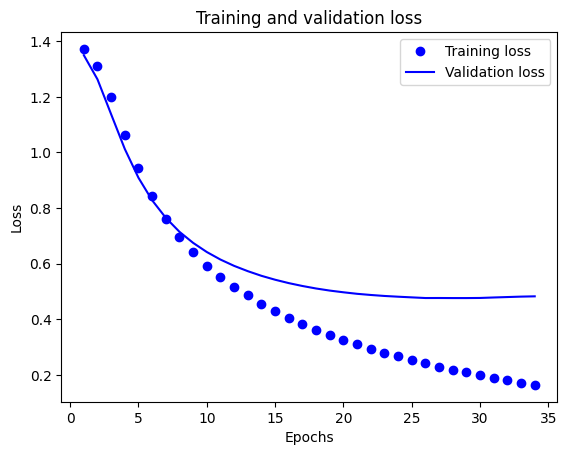

In [36]:
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

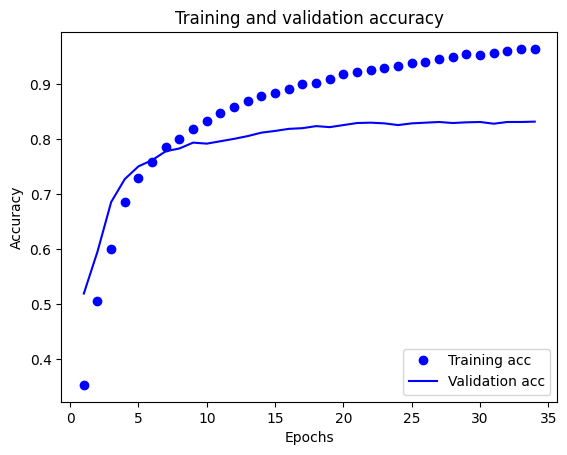

In [37]:
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

plt.show()

In [8]:
#

In [38]:
export_model = tf.keras.Sequential(
    [vectorize_layer, model, layers.Activation("sigmoid")]
)

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer="adam",
    metrics=["accuracy"],
)

loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

250/250 [==============================] - 4s 16ms/step - loss: 0.5381 - accuracy: 0.8019
0.8018749952316284


In [9]:
#

In [59]:
examples = [
    "In my application, I have a ListBox that has it's ItemsSource bound to a list of IScopeObject",
    "I used command in terminal pip install --upgrade pip and after that I cant use PIP command in Visual Studio Code",
    "I have a JTable with a MouseListener attached to it.",
    "I am making a comparison app, and for user experience, I'd like to implement a progress bar for the user to see.",
]

export_model.predict(examples)

1/1 [==============================] - 0s 45ms/step


array([[0.7124482 , 0.51869667, 0.39855382, 0.32800108],
       [0.6941498 , 0.2084719 , 0.29329625, 0.8496604 ],
       [0.49245712, 0.54195327, 0.57876265, 0.38978654],
       [0.5051755 , 0.42174664, 0.712013  , 0.38426894]], dtype=float32)

Лицензии, с которыми авторы используемого кода просят распространять его:

```
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


MIT License

Copyright (c) 2017 François Chollet

Permission is hereby granted, free of charge, to any person obtaining a
copy of this software and associated documentation files (the "Software"),
to deal in the Software without restriction, including without limitation
the rights to use, copy, modify, merge, publish, distribute, sublicense,
and/or sell copies of the Software, and to permit persons to whom the
Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in
all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
DEALINGS IN THE SOFTWARE.
```

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/text_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>
